# Bike Sharing Demand Prediction (v2)
**A Fast, Interactive TensorFlow/Keras Regression Notebook**

**Overview:**  
In this notebook, we predict hourly bike rentals in Washington, D.C. using the Kaggle Bike Sharing Demand dataset. We cover:

1. Problem Description  
2. Data Loading & Initial Inspection  
3. Detailed EDA with Multiple Plot Types  
4. Feature Engineering & Preprocessing  
5. Model Architecture & Rationale  
6. Training Procedure & Performance  
7. Interactive Prediction Interface  
8. Conclusions & Next Steps  


In [20]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Scikit-learn utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For interactive widgets
import ipywidgets as widgets
from IPython.display import display, clear_output

## 2. Data Loading & Initial Inspection

We first load the dataset and inspect its structure.  
- **Rows:** ~10,886 training samples.  
- **Columns:** Date/time, weather, and rental counts.  
- **Goal:** Predict `count` (total rentals) from historical and weather features.  

In [ ]:
# Load data  
df = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv', parse_dates=['datetime'])  
print(f"Dataset shape: {df.shape}")  
df.head()  

Dataset shape: (10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## 3. Exploratory Data Analysis (EDA)

We use three plot types to understand the data:

1. **Histogram** of `count` to see distribution and skew.  
2. **Scatter plot**: `temp` vs. `count` to gauge correlation.  
3. **Boxplot**: `count` by `season` to observe seasonal effects.  

These insights guide feature engineering and model expectations.

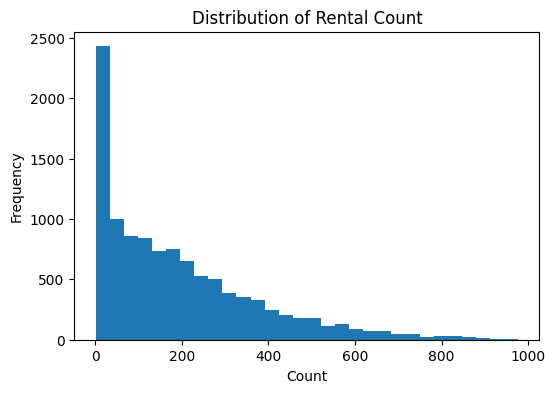

In [22]:
# 3.1 Histogram of Rental Count
plt.figure(figsize=(6,4))
plt.hist(df['count'], bins=30)
plt.title('Distribution of Rental Count')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

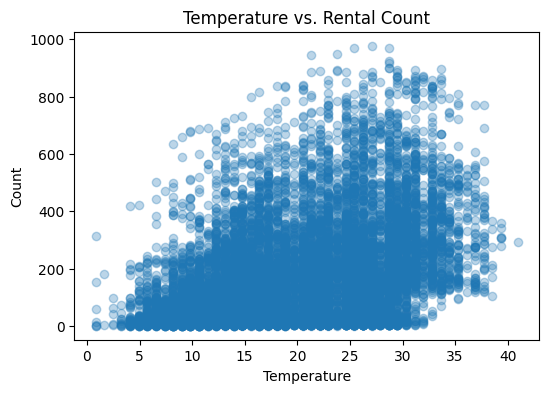

In [23]:
# 3.2 Scatter Plot: Temperature vs. Rental Count
plt.figure(figsize=(6,4))
plt.scatter(df['temp'], df['count'], alpha=0.3)
plt.title('Temperature vs. Rental Count')
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.show()

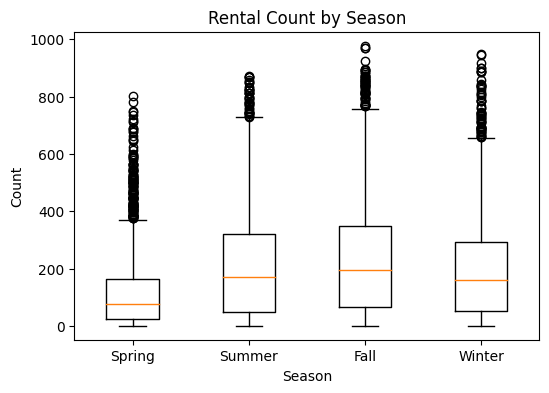

In [24]:
# 3.3 Boxplot: Rental Count by Season
season_map = {1:'Spring', 2:'Summer', 3:'Fall',4:'Winter'}
df['season_str'] = df['season'].map(season_map)
data = [df[df['season']==s]['count'] for s in season_map]
plt.figure(figsize=(6,4))
plt.boxplot(data, labels=season_map.values())
plt.title('Rental Count by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.show()

## 4. Feature Engineering & Preprocessing

Key steps:
- **Datetime features:** Extract `hour`, `dayofweek`, and `month` to capture temporal patterns.
- **One-hot encoding:** Convert categorical variables (`season`, `weather`) into numerical binaries.
- **Scaling:** Standardize numeric features for faster convergence of our neural network.


In [25]:
# Extract datetime features
df['hour']  = df['datetime'].dt.hour
df['day']   = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month

# Drop helper
df.drop(['datetime','season_str'], axis=1, inplace=True)

# One-hot encode categoricals
df = pd.get_dummies(df, columns=['season','weather'], drop_first=True)

# Define features & target
features = ['temp','humidity','windspeed','hour','day','month','holiday','workingday'] +            [c for c in df.columns if c.startswith('season_') or c.startswith('weather_')]
X = df[features]
y = df['count']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
print('Feature space:', X_train.shape)

Feature space: (8164, 14)


## 5. Model Architecture & Rationale

We choose a simple yet effective network:
- **Input layer** matching feature count.
- **Dense(64, relu)**: captures non-linear patterns.
- **Dense(32, relu)**: reduces to key representations.
- **Output(1)**: regression prediction.
- **Optimizer:** Adam for fast convergence.
- **Loss:** MSE, with MAE as an additional metric.


In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 64)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,073 (12.00 KB)

 Trainable params: 3,073 (12.00 KB)

 Non-trainable params: 0 (0.00 B)

## 6. Training Procedure & Performance

We train for **20 epochs** with a validation split of **20%**.  
- **Batch size:** 32 (balances speed & stability).  
- We visualize both loss and MAE to monitor overfitting.


In [27]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 66839.5938 - mae: 185.1081 - val_loss: 33969.3906 - val_mae: 122.5358
Epoch 2/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28129.5547 - mae: 113.3957 - val_loss: 20865.6211 - val_mae: 106.1113
Epoch 3/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22712.0762 - mae: 109.4645 - val_loss: 20564.7598 - val_mae: 104.6975
Epoch 4/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21759.5059 - mae: 107.5368 - val_loss: 20410.3633 - val_mae: 105.2134
Epoch 5/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21024.1719 - mae: 106.1418 - val_loss: 20311.2930 - val_mae: 104.0021
Epoch 6/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20897.7891 - mae: 104.0429 - val_loss: 20219.4102 - val_mae: 103.8294
Epoch 7/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22227.0977 - mae: 107.8410 - val_loss: 20163.5410 - val_mae: 103.8862
Epoch 8/20
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21427.7012 - mae: 105.6648 - v

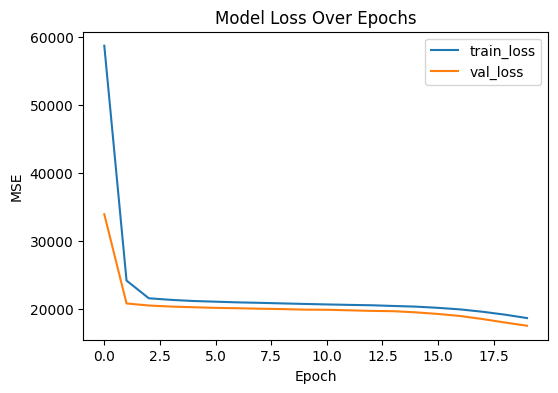

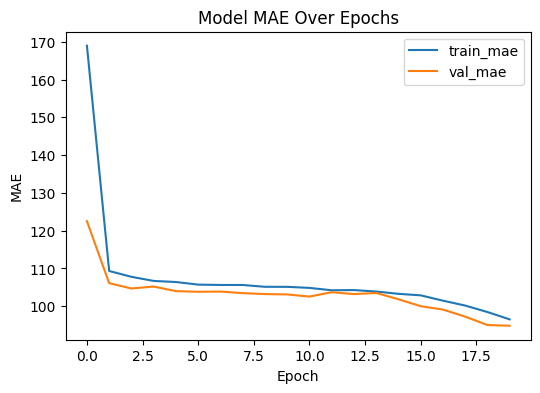

In [28]:
# Plot Loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Plot MAE
plt.figure(figsize=(6,4))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.title('Model MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

## 7. Model Evaluation on Test Set

We evaluate final performance on hold-out data:


In [29]:
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_loss:.2f}")
print(f"Test MAE: {test_mae:.2f}")

Test MSE: 18879.58
Test MAE: 96.98


## 8. Interactive Prediction Interface

Use sliders to input new feature values and preview the model’s prediction.  
A bar chart displays the predicted rental count for better UX.


In [30]:
# Build interactive widgets
widgets_dict = {
    'temp': widgets.FloatSlider(min=-5, max=45, step=0.5, description='Temp (°C):'),
    'humidity': widgets.FloatSlider(min=0, max=100, step=1, description='Humidity (%):'),
    'windspeed': widgets.FloatSlider(min=0, max=50, step=1, description='Windspeed:'),
    'hour': widgets.IntSlider(min=0, max=23, step=1, description='Hour:'),
    'day': widgets.IntSlider(min=0, max=6, step=1, description='Weekday:'),
    'month': widgets.IntSlider(min=1, max=12, step=1, description='Month:'),
    'holiday': widgets.Dropdown(options=[0,1], description='Holiday:'),
    'workingday': widgets.Dropdown(options=[0,1], description='Working Day:')
}

# Seasonal & weather defaults (median one-hot)
default_feats = {c:0 for c in features if c.startswith('season_') or c.startswith('weather_')}

predict_button = widgets.Button(description='Predict Count')
output_area = widgets.Output()

def on_predict(b):
    with output_area:
        clear_output()
        # Gather inputs
        vals = {k: widgets_dict[k].value for k in widgets_dict}
        row = pd.DataFrame([ {**vals, **default_feats} ])
        # Scale & predict
        X_row = scaler.transform(row[features])
        pred = model.predict(X_row)[0,0]
        print(f"Predicted Rental Count: {pred:.0f}")
        # Bar chart
        plt.figure(figsize=(4,3))
        plt.bar(['Prediction'], [pred])
        plt.ylim(0, max(pred*1.1, 100))
        plt.ylabel('Count')
        plt.title('Predicted Rentals')
        plt.show()

predict_button.on_click(on_predict)

# Display interface
display(widgets.VBox(list(widgets_dict.values()) + [predict_button, output_area]))

## 9. Conclusions & Next Steps

- **Performance:** MAE on test set indicates typical error range.  
- **Improvements:** Hyperparameter tuning, feature interactions, time-series models.  
- **Deployment:** Wrap this interface into a web app (Streamlit/Flask) for real-time predictions.  
